# Data Preprocessing

In [11]:
train_dataset = 'train.csv'
test_dataset = 'test.csv'

In [12]:
import pandas as pd

In [13]:
import pandas as pd
train_data = pd.read_csv(train_dataset, encoding='ISO-8859-1')
test_data = pd.read_csv(test_dataset,encoding="ISO-8859-1")
data = pd.concat([train_data,test_data])

In [14]:
data.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797.0,27400.0,105.0
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265.0,470.0,164.0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272.0,1246700.0,26.0


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32296 entries, 0 to 4814
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            31015 non-null  object 
 1   text              31014 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         31015 non-null  object 
 4   Time of Tweet     31015 non-null  object 
 5   Age of User       31015 non-null  object 
 6   Country           31015 non-null  object 
 7   Population -2020  31015 non-null  float64
 8   Land Area (Km²)   31015 non-null  float64
 9   Density (P/Km²)   31015 non-null  float64
dtypes: float64(3), object(7)
memory usage: 2.7+ MB


In [16]:
data.dropna(inplace=True)

In [17]:
final_corpus = data['text'].astype(str).tolist()
data_eda = pd.DataFrame()
data_eda['text'] = final_corpus
data_eda['sentiment'] = data["sentiment"].values
data_eda.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [18]:
import string
import re
def wp(text):
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
data_eda['text'] = data_eda["text"].apply(wp)

In [19]:
data_eda

,text,sentiment
0,Id have responded if I were going,neutral
1,Sooo SAD I will miss you here in San Diego,negative
2,my boss is bullying me,negative
3,what interview leave me alone,negative
4,Sons of why couldnt they put them on the rel...,negative
...,...,...
27475,wish we could come see u on Denver husband l...,negative
27476,Ive wondered about rake to The client has ma...,negative
27477,Yay good for both of you Enjoy the break you...,positive
27478,But it was worth it,positive


In [20]:
data_eda.to_csv("data_eda.csv", index=False)

In [21]:
data_eda['sentiment_code'] = data_eda['sentiment'].astype('category').cat.codes

## Feature Extraction

In [22]:
X=data_eda['text']
y= data_eda['sentiment_code']

## Word To Token

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()

In [24]:
tokenizer.fit_on_texts(X)

In [25]:
input_sequences = []
for sentence in X:
    tokenized_sentence = tokenizer.texts_to_sequences([sentence])[0]
    input_sequences.append(tokenized_sentence)

In [26]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
MAX_LENGTH = max([len(x) for x in input_sequences])
print(MAX_LENGTH)

32


In [27]:
enocoder_input = pad_sequences(input_sequences, maxlen=MAX_LENGTH, padding='pre')

# Model Building

In [28]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model

In [29]:
input = Input(shape=(MAX_LENGTH,))
x = Embedding(len(tokenizer.word_index)+1, 10)(input)
x = LSTM(64)(x)
output = Dense(3, activation='softmax')(x)

model = Model(input, output)

In [30]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [31]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 32, 10)              │         265,370 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          19,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 284,765 (1.09 MB)

 Trainable params: 284,765 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

# Training

In [32]:
history = model.fit(enocoder_input, y, epochs=10)

Epoch 1/10
859/859 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5058 - loss: 0.9708
Epoch 2/10
859/859 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7616 - loss: 0.5854
Epoch 3/10
859/859 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8330 - loss: 0.4332
Epoch 4/10
859/859 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8790 - loss: 0.3373
Epoch 5/10
859/859 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9066 - loss: 0.2661
Epoch 6/10
859/859 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9219 - loss: 0.2259
Epoch 7/10
859/859 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9332 - loss: 0.1974
Epoch 8/10
859/859 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9455 - loss: 0.1668
Epoch 9/10
859/859 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9509 - loss: 0.1487
Epoch 10/10
859/859 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9577 - loss: 0.1292


# Predicting

In [33]:
def SentimentAnalysis(text):
    sentece = [text]
    tokenized_sentence = tokenizer.texts_to_sequences(sentece)
    input_sequence = pad_sequences(tokenized_sentence, maxlen=MAX_LENGTH, padding='pre')
    prediction_ = model.predict(input_sequence)
    print(prediction_)
    prediction = prediction_.argmax()
    print(prediction)
    if prediction == 0:
        print(f"Negative 😠: [confidence - {prediction_[0][0]*100:.2f}%]")
    elif prediction == 1:
        print(f"Neutral 😐: [confidence - {prediction_[0][1]*100:.2f}%]")
    else:
        print(f"Positive 😊: [confidence -  {prediction_[0][2]*100:.2f}%]")
    plot = pd.DataFrame(prediction_, columns=['Negative', 'Neutral', 'Positive'])
    plot.plot(kind='barh')



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
[[0.91792476 0.06943099 0.01264416]]
0
Negative 😠: [confidence - 91.79%]


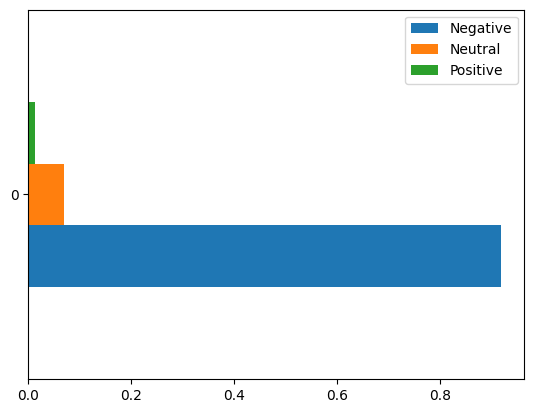

In [34]:
SentimentAnalysis("I am bad")

In [35]:
import pickle

# saving
with open('tokenizer.h5', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
!pip install gradio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.4/447.4 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/1

In [37]:
import gradio as gr
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Load the saved model
# e max length used in pad_sequences

# Sentiment Analysis Function
def SentimentAnalysis(text):
    sentence = [text]
    tokenized_sentence = tokenizer.texts_to_sequences(sentence)
    input_sequence = pad_sequences(tokenized_sentence, maxlen=MAX_LENGTH, padding='pre')

    # Predict sentiment
    prediction_ = model.predict(input_sequence)
    prediction = prediction_.argmax()

    if prediction == 0:
        sentiment = f"Negative 😠: [confidence - {prediction_[0][0]*100:.2f}%]"
    elif prediction == 1:
        sentiment = f"Neutral 😐: [confidence - {prediction_[0][1]*100:.2f}%]"
    else:
        sentiment = f"Positive 😊: [confidence -  {prediction_[0][2]*100:.2f}%]"

    return sentiment

# Create Gradio Interface
iface = gr.Interface(
    fn=SentimentAnalysis,  # Function to call
    inputs=gr.Textbox(lines=2, placeholder="Enter text for sentiment analysis"),  # Input textbox
    outputs="text",  # Output will be displayed as text
    title="Sentiment Analysis",  # App title
    description="This model analyzes the sentiment of the input text as Positive 😊, Neutral 😐, or Negative 😠.",  # App description
)

# Launch the interface
iface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://740a3577a2c87066ad.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
